In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, log_evaluation, record_evaluation
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
#from sklearn.impute import IterativeImputer
import pickle
import optuna
from optuna.visualization import plot_slice, plot_param_importances
import shap
import random

gc.enable()

pd.options.display.max_columns = None
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

#pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)
#optuna.logging.set_verbosity(optuna.logging.WARNING)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
os.listdir(path)

['features.csv',
 'imputed_train_ffill.parquet',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'team_folder',
 'test.parquet',
 'top_100000_rows_sorted_by_weight_descending.parquet',
 'top_10000_rows_sorted_by_weight_descending.parquet',
 'train.parquet']

In [4]:
train_df = pl.read_parquet(path + 'train.parquet/').drop(['responder_0', 'responder_1', 'responder_2', 'responder_3', 'responder_4', 'responder_5', 'responder_7', 'responder_8', 'partition_id']).select(pl.all().shrink_dtype())
print(train_df.shape)
train_df.head()

(47127338, 84)


date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,0,1,3.889038,null,null,null,null,null,0.851033,0.242971,0.2634,-0.891687,11,7,76,-0.883028,0.003067,-0.744703,null,-0.169586,null,-1.335938,-1.707803,0.91013,null,1.636431,1.522133,-1.551398,-0.229627,null,null,1.378301,-0.283712,0.123196,null,null,null,0.28118,0.269163,0.349028,-0.012596,-0.225932,null,-1.073602,null,null,-0.181716,null,null,null,0.564021,2.088506,0.832022,null,0.204797,null,null,-0.808103,null,-2.037683,0.727661,null,-0.989118,-0.345213,-1.36224,null,null,null,null,null,-1.251104,-0.110252,-0.491157,-1.02269,0.152241,-0.659864,null,null,-0.261412,-0.211486,-0.335556,-0.281498,0.775981
0,0,7,1.370613,null,null,null,null,null,0.676961,0.151984,0.192465,-0.521729,11,7,76,-0.865307,-0.225629,-0.582163,null,0.317467,null,-1.250016,-1.682929,1.412757,null,0.520378,0.744132,-0.788658,0.641776,null,null,0.2272,0.580907,1.128879,null,null,null,-1.512286,-1.414357,-1.823322,-0.082763,-0.184119,null,null,null,null,null,null,null,null,-10.835207,-0.002704,-0.621836,null,1.172836,null,null,-1.625862,null,-1.410017,1.063013,null,0.888355,0.467994,-1.36224,null,null,null,null,null,-1.065759,0.013322,-0.592855,-1.052685,-0.393726,-0.741603,null,null,-0.281207,-0.182894,-0.245565,-0.302441,0.703665
0,0,9,2.285698,null,null,null,null,null,1.056285,0.187227,0.249901,-0.77305,11,7,76,-0.675719,-0.199404,-0.586798,null,-0.814909,null,-1.296782,-2.040234,0.639589,null,1.597359,0.657514,-1.350148,0.364215,null,null,-0.017751,-0.317361,-0.122379,null,null,null,-0.320921,-0.95809,-2.436589,0.070999,-0.245239,null,null,null,null,null,null,null,null,-1.420632,-3.515137,-4.67776,null,0.535897,null,null,-0.72542,null,-2.29417,1.764551,null,-0.120789,-0.063458,-1.36224,null,null,null,null,null,-0.882604,-0.072482,-0.617934,-0.86323,-0.241892,-0.709919,null,null,0.377131,0.300724,-0.106842,-0.096792,2.109352
0,0,10,0.690606,null,null,null,null,null,1.139366,0.273328,0.306549,-1.262223,42,5,150,-0.694008,3.004091,0.114809,null,-0.251882,null,-1.902009,-0.979447,0.241165,null,-0.392359,-0.224699,-2.129397,-0.855287,null,null,0.404142,-0.578156,0.105702,null,null,null,0.544138,-0.087091,-1.500147,-0.201288,-0.038042,null,null,null,null,null,null,null,null,0.382074,2.669135,0.611711,null,2.413415,null,null,1.313203,null,-0.810125,2.939022,null,3.988801,1.834661,-1.36224,null,null,null,null,null,-0.697595,1.074309,-0.206929,-0.530602,4.765215,0.571554,null,null,-0.226891,-0.251412,-0.215522,-0.296244,1.114137
0,0,14,0.44057,null,null,null,null,null,0.9552,0.262404,0.344457,-0.613813,44,3,16,-0.947351,-0.030018,-0.502379,null,0.646086,null,-1.844685,-1.58656,-0.182024,null,-0.969949,-0.673813,-1.282132,-1.399894,null,null,0.043815,-0.320225,-0.031713,null,null,null,-0.08842,-0.995003,-2.635336,-0.196461,-0.618719,null,n

In [5]:
train_df.estimated_size() / 1e9

15.282841602

<Axes: xlabel='weight', ylabel='responder_6'>

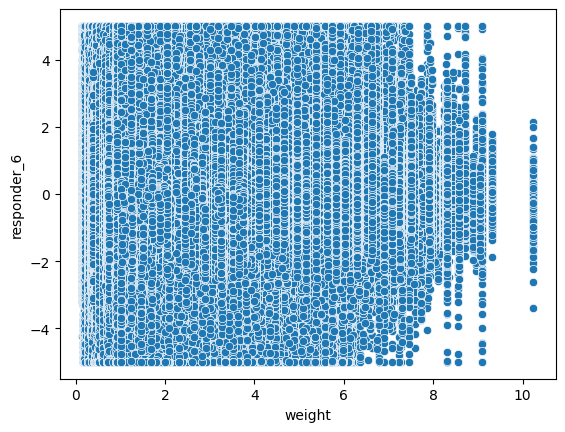

In [6]:
sns.scatterplot(x=train_df['weight'], y=train_df['responder_6'])

In [7]:
np.corrcoef(train_df['weight'], train_df['responder_6'])

array([[ 1.        , -0.00149359],
       [-0.00149359,  1.        ]])

In [ ]:
models_path = path + 'my_folder/models/20250111_03/'
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [ ]:
def lgb_sliding_window(train_data, optuna_n_trials):

    #unique_date_ids = sorted(train_data['date_id'].unique())
    unique_date_ids = [i for i in range(1110, train_data['date_id'].max()+1)]
    #date_ids_df = train_data['date_id'].to_frame()

    def objective(trial):
        val_window_size = trial.suggest_int('val_window_size', 1, 3)
        training_window_size = trial.suggest_int('training_window_size', 250, 350)
        n_samples = trial.suggest_int('n_samples', 1000000, 1500000)
        #fraction = trial.suggest_float('fraction', 0.05, 0.3)
        #sample_df = train_data.sample(fraction=fraction)
        #unique_date_ids = [i for i in range(1110, sample_df['date_id'].max()+1)]
        base_params = {
            'verbosity': -1,
            'device': 'gpu',
            'early_stopping_round': 20,
        }
        params_to_tune = {
            'learning_rate': trial.suggest_float('learning_rate', 0.04, 0.06),
            'max_depth': trial.suggest_int('max_depth', 12, 18),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 60, 100),
            'num_leaves': trial.suggest_int('num_leaves', 4000, 7000),
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.1, 0.25),
            'lambda_l1': trial.suggest_float('lambda_l1', 1, 4),
            'lambda_l2': trial.suggest_float('lambda_l2', 1500, 2000),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.9, 1),
        }

        scores_list = []
        for i in range(10):
            date_id = random.choice(unique_date_ids)
    
            test_date_id_df = train_data.filter(pl.col('date_id') == date_id)
    
            val_date_id_cut_lower = date_id - val_window_size
            val_window_df = train_data.filter((pl.col('date_id') < date_id)&(pl.col('date_id') >= val_date_id_cut_lower))#.sample(fraction=fraction)
    
            training_date_id_cut_lower = val_date_id_cut_lower - training_window_size
            training_window_df = train_data.filter((pl.col('date_id') < val_date_id_cut_lower)&(pl.col('date_id') >= training_date_id_cut_lower)).sample(n=n_samples)#.sort(by=['date_id', 'time_id', 'symbol_id'])
            #training_window_df = sample_df.filter((pl.col('date_id') >= training_date_id_cut_lower)&(pl.col('date_id') < val_date_id_cut_lower))#.sample(fraction=fraction).sort(by=['date_id', 'time_id', 'symbol_id'])
            #training_window_df = train_data.filter(pl.col('date_id') < val_date_id_cut_lower)[-500000:]
    
            '''
            print(date_id)
            print('this is training_window_df')
            display(training_window_df)
            print('training_window_size:', training_window_size)
            print('n unique in training_window_df:', training_window_df['date_id'].n_unique())
    
            print('this is val_window_df')
            display(val_window_df)
            print('val_window_size:', val_window_size)
            print('n unique in training_window_df:', val_window_df['date_id'].n_unique())
    
            print('this is test_date_id_df')
            display(test_date_id_df)
            print('n unique in test_date_id_df:', test_date_id_df['date_id'].n_unique())
            '''
    
            #training_window_df = training_window_df.sample(fraction=fraction)
                    
    
            '''
            print('this is window_df')
            display(window_df)
            print('this is date_id_df')
            display(date_id_df)
            '''
        
            model = LGBMRegressor(
                **base_params,
                **params_to_tune,
                n_estimators=100000
            )
        
            X_train = training_window_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
            X_val = val_window_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
            X_test = test_date_id_df.drop(['date_id', 'time_id', 'symbol_id', 'weight', 'responder_6']).select(pl.all().shrink_dtype()).to_pandas()
        
            y_train = training_window_df['responder_6'].to_pandas()
            y_val = val_window_df['responder_6'].to_pandas()
            y_test = test_date_id_df['responder_6'].to_pandas()
        
            weights_train = training_window_df['weight'].to_pandas()
            weights_val = val_window_df['weight'].to_pandas()
            weights_test = test_date_id_df['weight'].to_pandas()
        
            model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_sample_weight=[weights_train, weights_val])#, callbacks=[log_evaluation(period=10)])
            
            test_preds = model.predict(X_test)
    
            test_score = r2_score(y_test, test_preds, sample_weight=weights_test)

            scores_list.append(test_score)

        #print('Test Weighted R2 score is:', test_score)

        return np.mean(scores_list)

    with tqdm(total=optuna_n_trials, desc="Optimizing", unit="trial") as pbar:
    
        # Define a callback function to update the progress bar
        def progress_bar_callback(study, trial):
            pbar.update(1)
    
        study = optuna.create_study(direction="maximize")
        study.optimize(objective, n_trials=optuna_n_trials, callbacks=[progress_bar_callback])

    return study

In [ ]:
previous_best_params = {
    'val_window_size': 2,
    'training_window_size': 296,
    'learning_rate': 0.0536374109465744,
    'max_depth': 14,
    'min_data_in_leaf': 78,
    'num_leaves': 5071,
    'min_gain_to_split': 0.14337170358726214,
    'lambda_l1': 1.9610540335324638,
    'lambda_l2': 1708.4448845263755,
    'feature_fraction': 0.9010443799223739
}

In [ ]:
lgb_study = lgb_sliding_window(train_df, 100)

In [ ]:
for param in lgb_study.best_params.keys():
    fig = plot_slice(lgb_study, params=[param])
    fig.show()

In [ ]:
plot_param_importances(lgb_study)

In [ ]:
lgb_study.best_params

In [ ]:
lgb_study.best_value

In [ ]:
for k, v in lgb_study.best_params.items():
    print(k, v)

In [ ]:
lgb_params_df = pd.DataFrame({k:[v] for k, v in lgb_study.best_params.items()})

In [ ]:
lgb_params_df

In [ ]:
lgb_params_df.to_csv(models_path + 'lgb_params.csv', index=False)